In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Import data 
hdb = pd.read_csv('../data/hdb_final_dataset.csv')

# display first few rows of the dataframe
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238802 entries, 0 to 238801
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   month                       238802 non-null  object 
 1   town                        238802 non-null  object 
 2   block                       238802 non-null  object 
 3   street_name                 238802 non-null  object 
 4   storey_range                238802 non-null  object 
 5   floor_area_sqm              238802 non-null  float64
 6   flat_model                  238802 non-null  object 
 7   lease_commence_date         238802 non-null  int64  
 8   remaining_lease             238802 non-null  int64  
 9   adjusted_resale_price       238802 non-null  float64
 10  adj_resale_price_per_sqm    238802 non-null  float64
 11  address                     238802 non-null  object 
 12  latitude                    238802 non-null  float64
 13  longitude     

## HDB Prices analysis

Skewness more weight on left tail. Kurtosis, more weight in the middle compared to normal distribution

In [15]:
# Extract price and floor area
price = hdb['adjusted_resale_price']/1000 # in scaled in 1000
print(price.describe())

# Descriptive statistics for price
import scipy.stats
price_mean = np.mean(price)
price_median = np.median(price)
price_std = np.std(price)
price_kurtosis = scipy.stats.kurtosis(price)
price_skewness = scipy.stats.skew(price)
print(f"Mean: {price_mean}, Median: {price_median}, Std Dev: {price_std}, Kurtosis: {price_kurtosis}, Skewness: {price_skewness}")

count    238802.000000
mean        561.687544
std         186.510790
min         156.825000
25%         424.864940
50%         527.977500
75%         658.797144
max        1619.760000
Name: adjusted_resale_price, dtype: float64
Mean: 561.6875438977872, Median: 527.9775, Std Dev: 186.51039987585602, Kurtosis: 1.1013977346161283, Skewness: 0.9855469435323897


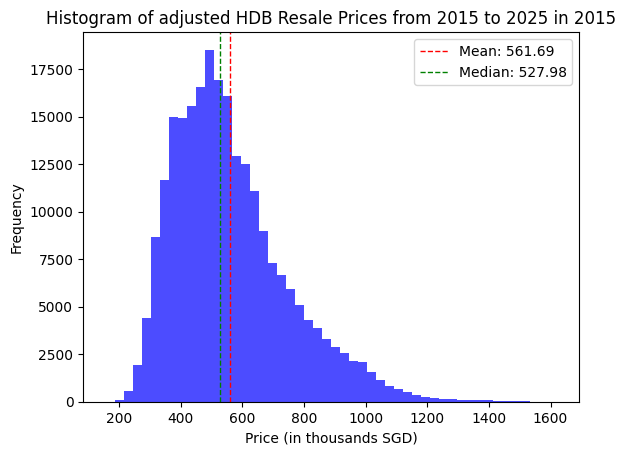

In [16]:
# Plot of histogram of prices
plt.hist(price, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of adjusted HDB Resale Prices from 2015 to 2025 in 2015')
plt.xlabel('Price (in thousands SGD)')
plt.ylabel('Frequency')

# plot mean, median 
plt.axvline(price.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean: {:.2f}'.format(price.mean()))
plt.axvline(price.median(), color='green', linestyle='dashed', linewidth=1, label='Median: {:.2f}'.format(price.median()))
plt.legend()

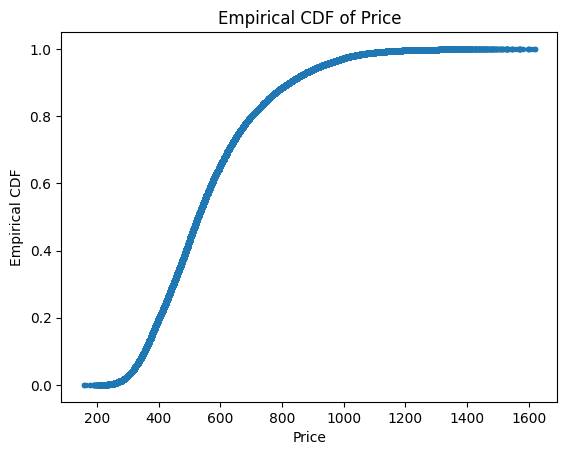

In [17]:
# Plot empirical CDF
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(price)

plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.xlabel("Price")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of Price")
plt.show()


Checking Normality of Price

Anderson-Darling Test Statistic: 3357.5071811359667
At 15.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 3357.5071811359667 >= critical value: 0.576)
At 10.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 3357.5071811359667 >= critical value: 0.656)
At 5.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 3357.5071811359667 >= critical value: 0.787)
At 2.5% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 3357.5071811359667 >= critical value: 0.918)
At 1.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 3357.5071811359667 >= critical value: 1.092)
Shapiro-Wilk Test Statistic: 0.9430626275060147
Shapiro-Wilk Test p-value: 3.1785647835655923e-114


c:\Users\Josiah Lee\Documents\GitHub\EC4305-Project\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 238802.
  res = hypotest_fun_out(*samples, **kwds)


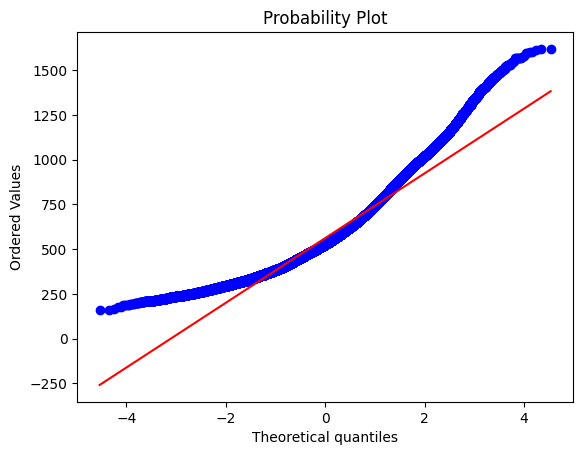

In [18]:
# Normality check with Q-Q plot
import scipy.stats as stats
stats.probplot(price, dist="norm", plot=plt)

# normality test using AD test better for large sample sizes
from scipy.stats import anderson
price_normal = anderson(price, dist='norm')
print("Anderson-Darling Test Statistic:", price_normal.statistic)
for i in range(len(price_normal.critical_values)):
    sl, cv = price_normal.significance_level[i], price_normal.critical_values[i]
    if price_normal.statistic < cv:
        print(f"At {sl}% significance level, the null hypothesis that data is normally distributed cannot be rejected (statistic: {price_normal.statistic} < critical value: {cv})")
    else:
        print(f"At {sl}% significance level, the null hypothesis that data is normally distributed is rejected (statistic: {price_normal.statistic} >= critical value: {cv})")
# test result shows strong rejection against null hypothesis that data is normally distributed thus data is likely not normal

# normalisty test using Shapiro-Wilk test
from scipy.stats import shapiro
shapiro_test = shapiro(price)
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

### Testing for various distribution for price

#### Log-normal distribution

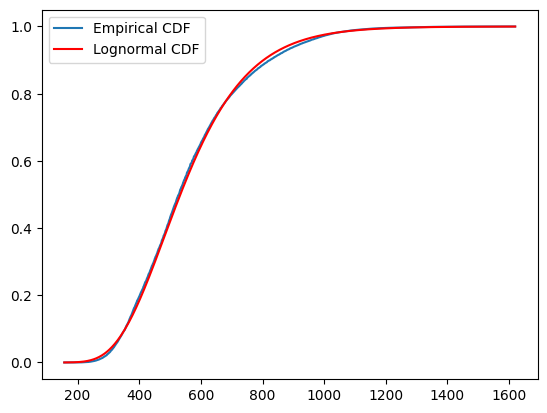

In [19]:
from scipy.stats import lognorm
log_shape, log_loc, log_scale = lognorm.fit(price, floc=0)

x = np.linspace(min(price), max(price), 1500)
plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, lognorm.cdf(x, log_shape, loc=log_loc, scale=log_scale), label="Lognormal CDF", color='red')    
plt.legend()



#### Gamma distribution

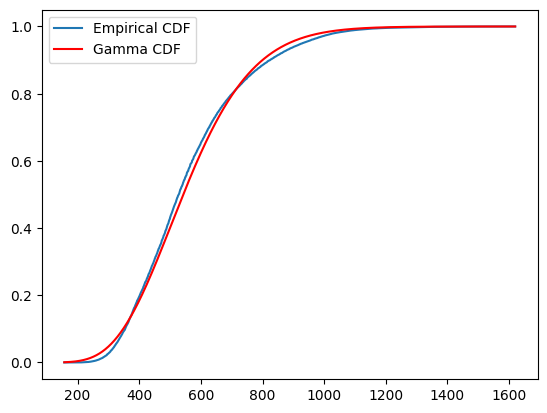

In [20]:
from scipy.stats import gamma

# Fit gamma distribution
g_shape, g_loc, g_scale = gamma.fit(price, floc=0)

plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, gamma.cdf(x, g_shape, loc=g_loc, scale=g_scale),
         label="Gamma CDF", color="red")
plt.legend()
plt.show()


#### Weibull distribution

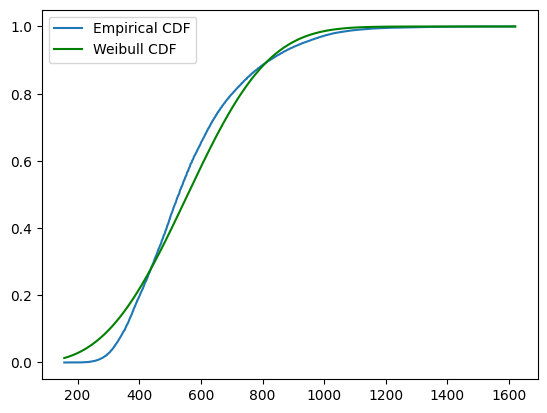

In [21]:
from scipy.stats import weibull_min

weibull_params = weibull_min.fit(price, floc=0)
w_c, w_loc, w_scale = weibull_params

plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, weibull_min.cdf(x, w_c, loc=w_loc, scale=w_scale),
         label="Weibull CDF", color="green")

plt.legend()

T-distribution

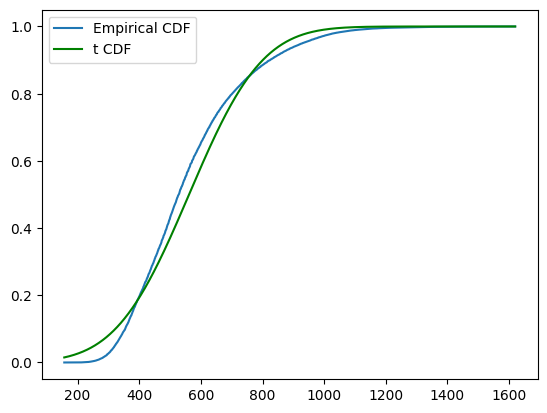

In [22]:
from scipy.stats import t

t_params = t.fit(price)
t_df, t_loc, t_scale = t_params

plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, t.cdf(x, t_df, loc=t_loc, scale=t_scale),
         label="t CDF", color="green")
plt.legend()

#### Kernel density

Trying out different widths

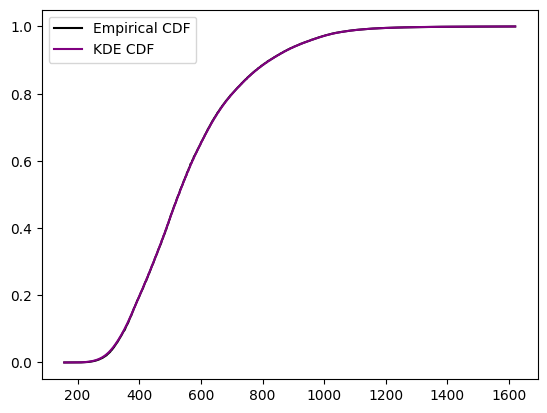

In [23]:
# estimate using kernel density estimation
from scipy.stats import gaussian_kde
from scipy.integrate import cumulative_trapezoid

kde_price = gaussian_kde(price) # using scotts rule for bandwidth selection by default
pdf_kde_price = kde_price(x)

cdf_kde_price = cumulative_trapezoid(pdf_kde_price, x, initial=0)
cdf_kde_price /= cdf_kde_price[-1] 


plt.plot(x, ECDF(price)(x), label="Empirical CDF", color='black')
plt.plot(x, cdf_kde_price, label="KDE CDF", color='purple')
plt.legend()


Testing to see if log price follow normal, loks like might follow t distribution better

((array([-4.53336288, -4.34243606, -4.23885493, ...,  4.23885493,
          4.34243606,  4.53336288], shape=(238802,)),
  array([3.3202342 , 3.3202342 , 3.34115718, ..., 4.08702167, 4.08835926,
         4.08835926], shape=(238802,))),
 (np.float64(0.10288107904519946),
  np.float64(3.7599461726806984),
  np.float64(0.9990195773198327)))

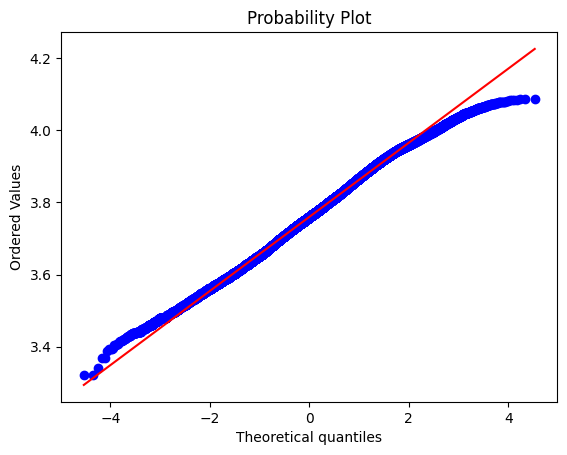

In [26]:
import scipy.stats as stats
log_price = np.log(price)
mu, sigma = stats.norm.fit(log_price)

# stats.probplot(log_price, dist="norm", plot=plt)

import scipy.stats
boxcox_price, fitted_lambda = scipy.stats.boxcox(price)
stats.probplot(boxcox_price, dist="norm", plot=plt)

In [9]:
from scipy.stats import t

t_params = t.fit(log_price)
t_df, t_loc, t_scale = t_params

plt.plot(x, ECDF(log_price)(x), label="Empirical CDF")
plt.plot(x, t.cdf(x, t_df, loc=t_loc, scale=t_scale),
         label="t CDF", color="green")
plt.legend()

NameError: name 'x' is not defined

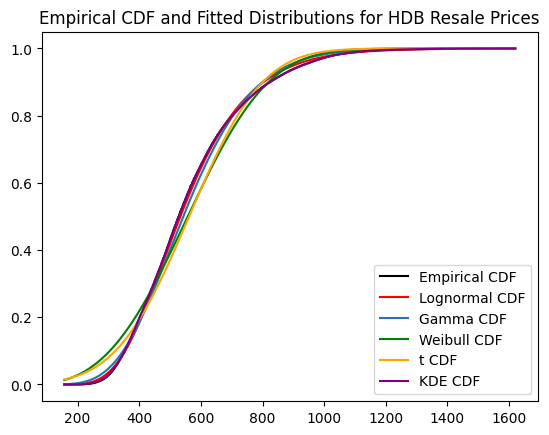

In [ ]:
# All plots together
plt.plot(x, ECDF(price)(x), label="Empirical CDF", color='black')
plt.plot(x, lognorm.cdf(x, log_shape, loc=log_loc, scale=log_scale), label="Lognormal CDF", color='red')
plt.plot(x, gamma.cdf(x, g_shape, loc=g_loc, scale=g_scale), label="Gamma CDF")
plt.plot(x, weibull_min.cdf(x, w_c, loc=w_loc, scale=w_scale), label="Weibull CDF", color="green")
plt.plot(x, t.cdf(x, t_df, loc=t_loc, scale=t_scale), label="t CDF", color="orange")
plt.plot(x, cdf_kde_price, label="KDE CDF", color='purple')

plt.legend()
plt.title("Empirical CDF and Fitted Distributions for HDB Resale Prices")
plt.show()


#### Goodness of fit via AIC/BIC

im quite sure k = 3 cos estimating 3 params


In [ ]:
# Goodness of fit via AIC/BIC

def AIC(logL, k):
    return 2*k - 2*logL

def BIC(n, logL, k):
    return k*np.log(n) - 2*logL

# Log-likelihood
loglik_lognorm = np.sum(lognorm.logpdf(price, log_shape, loc=log_loc, scale=log_scale))
aic_lognorm = AIC(loglik_lognorm, k=3)
bic_lognorm = BIC(len(price), loglik_lognorm, k=3)

# gamma
loglik_gamma = np.sum(gamma.logpdf(price, g_shape, loc=g_loc, scale=g_scale))
aic_gamma = AIC(loglik_gamma, k=3)
bic_gamma = BIC(len(price), loglik_gamma, k=3)

# weibull
loglik_weibull = np.sum(weibull_min.logpdf(price, w_c, loc=w_loc, scale=w_scale))
aic_weibull = AIC(loglik_weibull, k=3)
bic_weibull = BIC(len(price), loglik_weibull, k=3) 

# t-distribution
loglik_t = np.sum(t.logpdf(price, t_df, loc=t_loc, scale=t_scale))
aic_t = AIC(loglik_t, k=3)
bic_t = BIC(len(price), loglik_t, k=3)

# T distribution
loglik_t = np.sum(t.logpdf(price, t_df, loc=t_loc, scale=t_scale))
aic_t = AIC(loglik_t, k=3)
bic_t = BIC(len(price), loglik_t, k=3)

ic_results = pd.DataFrame({
    'Distribution': ['Lognormal', 'Gamma', 'Weibull', 'T'],
    'AIC': [aic_lognorm, aic_gamma, aic_weibull, aic_t],
    'BIC': [bic_lognorm, bic_gamma, bic_weibull, bic_t]
})

print(ic_results.sort_values(by='AIC'))


     Distribution           AIC           BIC
0       Lognormal  3.131415e+06  3.131446e+06
1           Gamma  3.138587e+06  3.138618e+06
2         Weibull  3.174521e+06  3.174552e+06
3  t-Distribution  3.174843e+06  3.174874e+06


From the results above, Log normal distribution has the lowest AIC and BIC, and therefore is the best fitted distribution amongst the 3 parametric distributions. However, let's compare log-normal distribution against non-parametric ECDF marginal distribution using the KS test 

In [ ]:
from scipy.stats import kstest

ks_lognorm = kstest(price, 'lognorm', args=(log_shape, log_loc, log_scale))
print(ks_lognorm)

KstestResult(statistic=0.01641537384657954, pvalue=2.5144589487794603e-56, statistic_location=566.4937199999999, statistic_sign=1)


The lognormal distribution produces an excellent visual fit to the empirical CDF of prices (Figure X). Although the KS test rejects lognormality at any conventional significance level, this is expected given the very large sample size, where even negligible differences become statistically significant. However, the visual fit, AIC comparison, and overall curvature match strongly support the lognormal model as a reasonable parametric marginal for resale price

### Measure CDF distance from empirical CDF

In [ ]:
# Measure cdf distance from empirical cdf

def cdf_distance(empirical_cdf, model_cdf, x):
    diff = empirical_cdf - model_cdf
    
    sup_norm = np.max(np.abs(diff))               
    ise = np.trapz(diff**2, x)  
    return sup_norm, ise

dist_lognorm = cdf_distance(ECDF(price)(x), lognorm.cdf(x, log_shape, loc=log_loc, scale=log_scale), x)
dist_gamma = cdf_distance(ECDF(price)(x), gamma.cdf(x, g_shape, loc=g_loc, scale=g_scale), x)
dist_weibull = cdf_distance(ECDF(price)(x), weibull_min.cdf(x, w_c, loc=w_loc, scale=w_scale), x)
dist_t = cdf_distance(ECDF(price)(x), t.cdf(x, t_df, loc=t_loc, scale=t_scale), x)
dist_kde = cdf_distance(ECDF(price)(x), cdf_kde_price, x)

distance_results = pd.DataFrame({
    'Distribution': ['Lognormal', 'Gamma', 'Weibull', 't-Distribution', 'KDE'],
    'Sup Distance': [dist_lognorm[0], dist_gamma[0], dist_weibull[0], dist_t[0], dist_kde[0]],
    'ISE':          [dist_lognorm[1], dist_gamma[1], dist_weibull[1], dist_t[1], dist_kde[1]]
}).sort_values(by='Sup Distance')

print(distance_results)


     Distribution  Sup Distance       ISE
4             KDE      0.004032  0.000996
0       Lognormal      0.016067  0.070952
1           Gamma      0.037812  0.296262
2         Weibull      0.073992  1.523568
3  t-Distribution      0.080561  1.444996


#### MGF estimate for price

Text(0.5, 1.0, 'MGF Comparison')

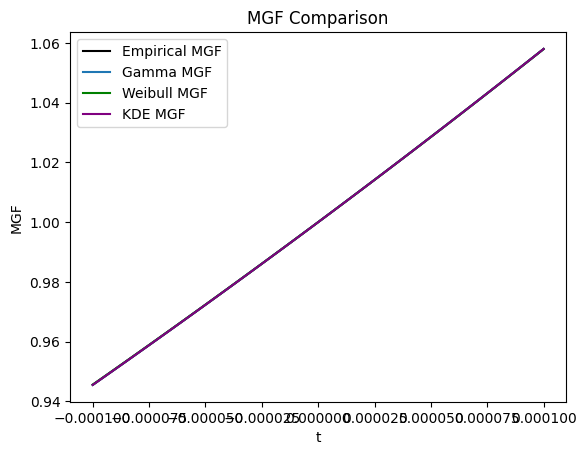

In [ ]:
# MGF estimate for price
def mgf_empirical(data, t):
    return np.mean(np.exp(t * data))

t_values = np.linspace(-0.0001, 0.0001, 100)
mgf_empirical_values = [mgf_empirical(price, t) for t in t_values]

# MGF for fitted gamma
def mgf_gamma(t, shape, scale):
    return (1 - scale * t) ** -shape
mgf_gamma_values = [mgf_gamma(t, g_shape, g_scale) for t in t_values]

# MGF for fitted weibull
from scipy.special import gamma as gamma_func
import math
def mgf_weibull(t, c, scale):
    return sum((t**n / math.factorial(n)) * (scale**n) * gamma_func(1 + n/c) for n in range(100))
mgf_weibull_values = [mgf_weibull(t, w_c, w_scale) for t in t_values]

# MGF for KDE
def mgf_kde(t, x_grid, pdf_kde):
    integrand = np.exp(t * x_grid) * pdf_kde
    return np.trapz(integrand, x_grid) 

mgf_kde_values = [mgf_kde(t, x, pdf_kde_price) for t in t_values]


# Plot MGF comparisons
plt.plot(t_values, mgf_empirical_values, label='Empirical MGF', color='black')
plt.plot(t_values, mgf_gamma_values, label='Gamma MGF')
plt.plot(t_values, mgf_weibull_values, label='Weibull MGF', color='green')
plt.plot(t_values, mgf_kde_values, label='KDE MGF', color='purple')
plt.xlabel('t')
plt.ylabel('MGF')
plt.legend()
plt.title('MGF Comparison')


## Floor area analysis

More weight on left tail, less heavy tail than norm distribution

In [ ]:
floor_area = hdb['floor_area_sqm']
print(floor_area.describe())

# Descriptive statistics for floor_area
import scipy.stats
floor_area_mean = np.mean(floor_area)
floor_area_median = np.median(floor_area)
floor_area_std = np.std(floor_area)
floor_area_kurtosis = scipy.stats.kurtosis(floor_area)
floor_area_skewness = scipy.stats.skew(floor_area)
print(f"Mean: {floor_area_mean}, Median: {floor_area_median}, Std Dev: {floor_area_std}, Kurtosis: {floor_area_kurtosis}, Skewness: {floor_area_skewness}")

count    238802.000000
mean         96.961016
std          24.055285
min          31.000000
25%          81.000000
50%          93.000000
75%         112.000000
max         366.700000
Name: floor_area_sqm, dtype: float64
Mean: 96.96101582063802, Median: 93.0, Std Dev: 24.055234486281588, Kurtosis: -0.010082655673690155, Skewness: 0.26830692551692154


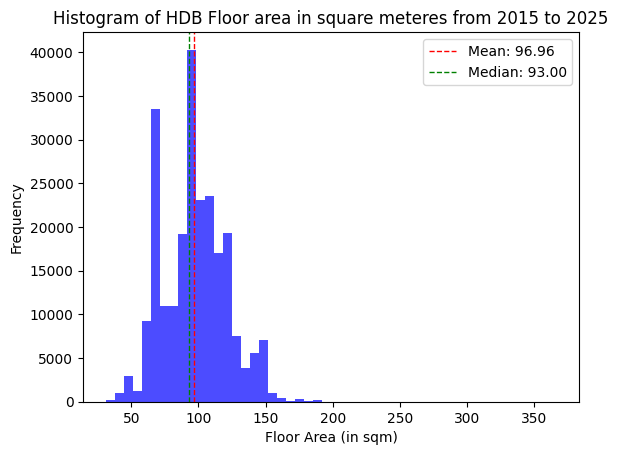

In [ ]:
# Plot of histogram of floor area
plt.hist(floor_area, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of HDB Floor area in square meteres from 2015 to 2025')
plt.xlabel('Floor Area (in sqm)')
plt.ylabel('Frequency')

# plot mean, median 
plt.axvline(floor_area.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean: {:.2f}'.format(floor_area.mean()))
plt.axvline(floor_area.median(), color='green', linestyle='dashed', linewidth=1, label='Median: {:.2f}'.format(floor_area.median()))
plt.legend()

Text(0.5, 1.0, 'Empirical CDF of Floor Area')

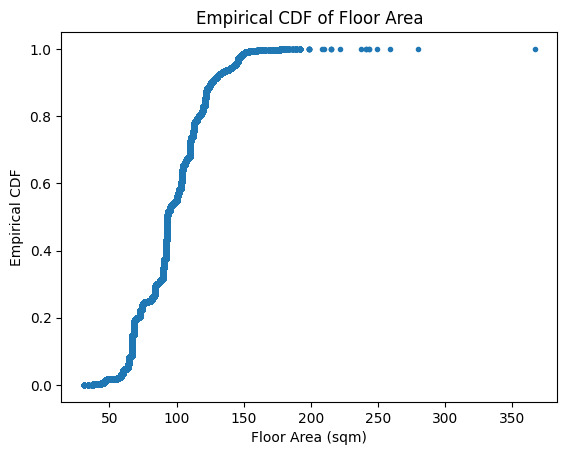

In [ ]:
# Plot empirical CDF
ecdf_area = ECDF(floor_area)
plt.plot(ecdf_area.x, ecdf_area.y, marker='.', linestyle='none')
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of Floor Area")


Anderson-Darling Test Statistic: 1487.9404758889577
At 15.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 1487.9404758889577 >= critical value: 0.576)
At 10.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 1487.9404758889577 >= critical value: 0.656)
At 5.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 1487.9404758889577 >= critical value: 0.787)
At 2.5% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 1487.9404758889577 >= critical value: 0.918)
At 1.0% significance level, the null hypothesis that data is normally distributed is rejected (statistic: 1487.9404758889577 >= critical value: 1.092)
Shapiro-Wilk Test Statistic: 0.9812183389728184
Shapiro-Wilk Test p-value: 2.1206639900182188e-85


/var/folders/2h/gvrjdw1x6t766jgk66w62_tw0000gn/T/ipykernel_7363/1728706104.py:19: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 238802.
  shapiro_test = shapiro(floor_area)


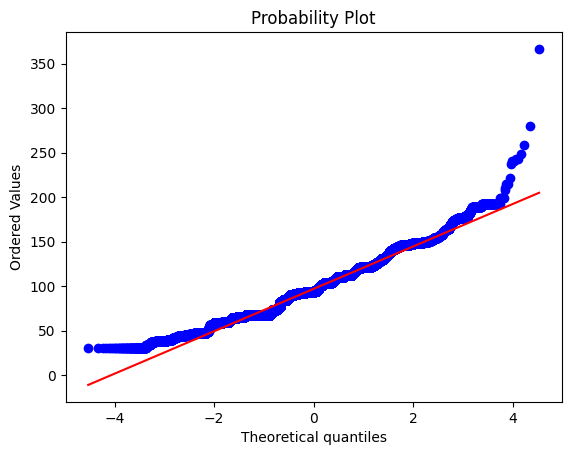

In [ ]:
# Normality check with Q-Q plot
stats.probplot(floor_area, dist="norm", plot=plt)

# normality test using AD test
from scipy.stats import anderson
floor_area_normal = anderson(floor_area, dist='norm')
print("Anderson-Darling Test Statistic:", floor_area_normal.statistic)
for i in range(len(floor_area_normal.critical_values)):
    sl, cv = floor_area_normal.significance_level[i], floor_area_normal.critical_values[i]
    if floor_area_normal.statistic < cv:
        print(f"At {sl}% significance level, the null hypothesis that data is normally distributed cannot be rejected (statistic: {floor_area_normal.statistic} < critical value: {cv})")
    else:
        print(f"At {sl}% significance level, the null hypothesis that data is normally distributed is rejected (statistic: {floor_area_normal.statistic} >= critical value: {cv})")
# test result shows strong rejection against null hypothesis that data is normally distributed thus data is likely not normal


# normalisty test using Shapiro-Wilk test
from scipy.stats import shapiro
shapiro_test = shapiro(floor_area)
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

### Testing for various distribution for floor area

##### Mixture of gaussian distribution

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model from 1 to 7 components
floor_area_gmm = floor_area.values.reshape(-1, 1)

aic_scores = []
bic_scores = []
k = range(1, 8)
for n_components in k:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(floor_area_gmm)
    aic_scores.append(gmm.aic(floor_area_gmm))
    bic_scores.append(gmm.bic(floor_area_gmm))

print(pd.DataFrame({'Components': k, 'AIC': aic_scores, 'BIC': bic_scores}).sort_values(by='AIC')) # based on IC, 5 components is optimal

   Components           AIC           BIC
4           5  2.109940e+06  2.110085e+06
6           7  2.117491e+06  2.117699e+06
3           4  2.120308e+06  2.120422e+06
5           6  2.122896e+06  2.123072e+06
2           3  2.177115e+06  2.177198e+06
1           2  2.195211e+06  2.195262e+06
0           1  2.196644e+06  2.196665e+06


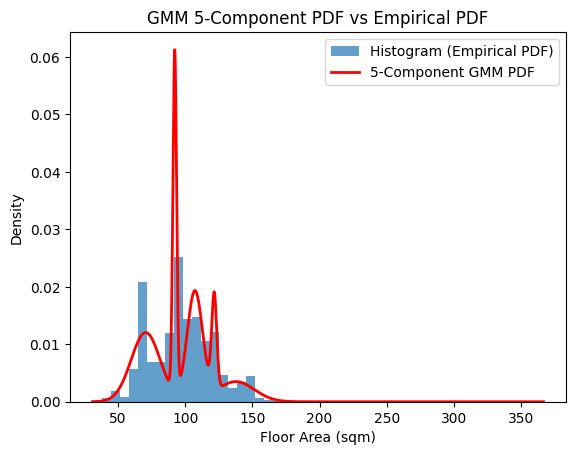

In [ ]:
# Plot of 5-component GMM fit
optimal_gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
optimal_gmm.fit(floor_area_gmm)
x_area = np.linspace(min(floor_area), max(floor_area), 1500).reshape(-1, 1)
logprob = optimal_gmm.score_samples(x_area)
pdf_gmm_floor_area = np.exp(logprob)

# Histogram (empirical PDF)
plt.hist(floor_area, bins=50, density=True, alpha=0.7, label="Histogram (Empirical PDF)")

# GMM PDF
plt.plot(x_area, pdf_gmm_floor_area, linewidth=2, color='red', label='5-Component GMM PDF')

plt.xlabel("Floor Area (sqm)")
plt.ylabel("Density")
plt.title("GMM 5-Component PDF vs Empirical PDF")
plt.legend()


In [ ]:
# Check the weights for each component
weights_gmm = optimal_gmm.weights_
print("GMM Component Weights:", weights_gmm)
# Check the means for each component
means_gmm = optimal_gmm.means_.flatten()
print("GMM Component Means:", means_gmm)
# Check the covariances for each component
covariances_gmm = optimal_gmm.covariances_.flatten()
print("GMM Component Covariances:", covariances_gmm)


GMM Component Weights: [0.32667398 0.27505107 0.12061738 0.20106988 0.07658769]
GMM Component Means: [ 70.51884345 107.16046963 137.67499877  92.17547927 121.56042643]
GMM Component Covariances: [117.01641683  33.2929881  188.43820155   1.84839796   3.40974933]


#### Mixture of lognormal distributions

In [ ]:
log_area = np.log(floor_area.values.reshape(-1,1))
aic_scores = []
bic_scores = []
k = range(1, 8)
for n_components in k:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(log_area)
    aic_scores.append(gmm.aic(log_area))
    bic_scores.append(gmm.bic(log_area))

print(pd.DataFrame({'Components': k, 'AIC': aic_scores, 'BIC': bic_scores}).sort_values(by='AIC')) # based on IC, 7 components is optimal


   Components           AIC           BIC
6           7 -96553.447393 -96345.779592
5           6 -85083.597799 -84907.080168
3           4 -46582.874663 -46468.657373
4           5 -39302.736902 -39157.369441
2           3   7451.731371   7534.798491
1           2  18214.490389  18266.407339
0           1  31037.116366  31057.883146


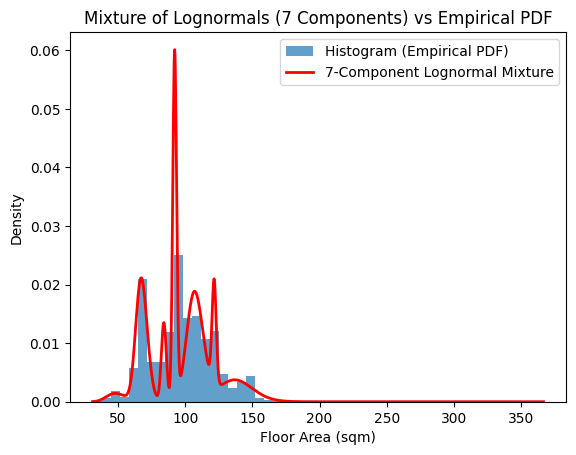

In [ ]:
# Fit 7-component GMM on log(area)
optimal_gmm_log = GaussianMixture(n_components=7, covariance_type='full', random_state=0)
optimal_gmm_log.fit(log_area)
x_area = np.linspace(min(floor_area), max(floor_area), 1500)

# Extract parameters
weights_lognormal = optimal_gmm_log.weights_
means_lognormal = optimal_gmm_log.means_.flatten()
stds_lognormal = np.sqrt(optimal_gmm_log.covariances_.flatten())

# Construct mixture of lognormals PDF
pdf_mix_lognormal = np.zeros_like(x_area)
for w, mu, sigma in zip(weights_lognormal, means_lognormal, stds_lognormal):
    pdf_mix_lognormal += w * (
        1 / (x_area * sigma * np.sqrt(2*np.pi))
        * np.exp(-(np.log(x_area) - mu)**2 / (2*sigma**2))
    )

# Plot histogram + mixture
plt.hist(floor_area, bins=50, density=True, alpha=0.7, label="Histogram (Empirical PDF)")
plt.plot(x_area, pdf_mix_lognormal, linewidth=2, color='red', label='7-Component Lognormal Mixture')
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Density")
plt.title("Mixture of Lognormals (7 Components) vs Empirical PDF")
plt.legend()



#### KDE estimate

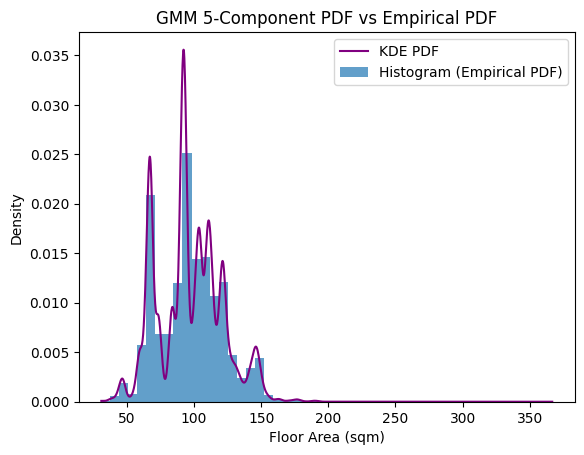

In [ ]:
# KDE Estimate for floor area
from scipy.stats import gaussian_kde
from scipy.integrate import cumulative_trapezoid

kde_floor_area = gaussian_kde(floor_area)
pdf_kde_floor_area = kde_floor_area(x_area.flatten())
plt.plot(x_area, pdf_kde_floor_area, label="KDE PDF", color='purple')
plt.hist(floor_area, bins=50, density=True, alpha=0.7, label="Histogram (Empirical PDF)")
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Density")
plt.title("GMM 5-Component PDF vs Empirical PDF")
plt.legend()



#### Compare fit using CDF distance

In [ ]:
from scipy.stats import norm, lognorm

area = np.linspace(floor_area.min(), floor_area.max(), 1500)

# Empirical CDF
ecdf = ECDF(floor_area)
emp_cdf = ecdf(area)

# CDF for GMM original scale
K_gmm = 5
gmm = GaussianMixture(n_components=K_gmm, covariance_type='full', random_state=0)
gmm.fit(floor_area.values.reshape(-1,1))
weights_gmm = gmm.weights_
means_gmm   = gmm.means_.flatten()
stds_gmm    = np.sqrt(gmm.covariances_.flatten())
gmm_cdf = np.zeros_like(area)
for w, m, s in zip(weights_gmm, means_gmm, stds_gmm):
    gmm_cdf += w * norm.cdf(area, loc=m, scale=s) 
sup_gmm, ise_gmm = cdf_distance(emp_cdf, gmm_cdf, area)

# CDF for mixture of lognormals
K_lognormal = 7
weights_lognormal = optimal_gmm_log.weights_
means_lognormal = optimal_gmm_log.means_.flatten()
stds_lognormal = np.sqrt(optimal_gmm_log.covariances_.flatten())
lognormal_cdf = np.zeros_like(area)
for w, mu, sigma in zip(weights_lognormal, means_lognormal, stds_lognormal):
    lognormal_cdf += w * lognorm.cdf(area, s=sigma, scale=np.exp(mu))
sup_lognormal, ise_lognormal = cdf_distance(emp_cdf, lognormal_cdf, area)

# CDF for KDE
kde_cdf = cumulative_trapezoid(pdf_kde_floor_area, area, initial=0)
kde_cdf /= kde_cdf[-1]
sup_kde, ise_kde = cdf_distance(emp_cdf, kde_cdf, area)

# Compile distance results
distance_results_area = pd.DataFrame({
    'Model': ['GMM (5 components)', 'Mixture of Lognormals (7 components)', 'KDE'],
    'Sup Distance': [sup_gmm, sup_lognormal, sup_kde],
    'ISE':          [ise_gmm, ise_lognormal, ise_kde]
}).sort_values(by='Sup Distance')
print(distance_results_area)


                                  Model  Sup Distance       ISE
1  Mixture of Lognormals (7 components)      0.039358  0.009130
2                                   KDE      0.053376  0.009835
0                    GMM (5 components)      0.054907  0.023186


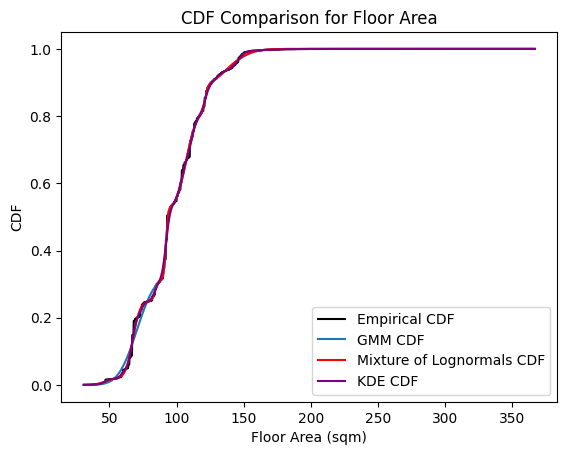

In [ ]:
# Plot all CDFs together
plt.plot(area, emp_cdf, label="Empirical CDF", color='black')
plt.plot(area, gmm_cdf, label="GMM CDF")
plt.plot(area, lognormal_cdf, label="Mixture of Lognormals CDF", color='red')
plt.plot(area, kde_cdf, label="KDE CDF", color='purple')
plt.xlabel("Floor Area (sqm)")
plt.ylabel("CDF")
plt.title("CDF Comparison for Floor Area")
plt.legend()


#### MGF estimate for floor area

Text(0.5, 1.0, 'MGF Comparison for Floor Area')

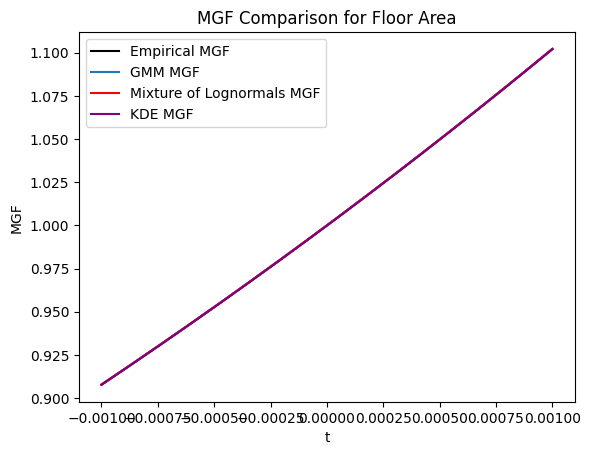

In [ ]:
from scipy.integrate import trapezoid

def mgf_gmm(t, weights, means, stds):
    return np.sum([
        w * np.exp(m * t + 0.5 * (s**2) * t**2)
        for w, m, s in zip(weights, means, stds)
    ])

def mgf_lognormal_mix(t, x_grid, weights, means, sigmas):
    pdf_vals = np.zeros_like(x_grid)
    for w, mu, sigma in zip(weights, means, sigmas):
        pdf_vals += w * lognorm.pdf(x_grid, s=sigma, scale=np.exp(mu))
    return trapezoid(np.exp(t * x_grid) * pdf_vals, x_grid)

t_values = np.linspace(-0.001, 0.001, 200)
mgf_empirical_values_area = [mgf_empirical(floor_area, t) for t in t_values]
mgf_gmm_values = [mgf_gmm(t, weights_gmm, means_gmm, stds_gmm) for t in t_values]
mgf_lognormal_values = [mgf_lognormal_mix(t, area, weights_lognormal, means_lognormal, stds_lognormal) for t in t_values]
mgf_kde_values_area = [mgf_kde(t, area, pdf_kde_floor_area) for t in t_values]

# Plot MGF comparisons for floor area
plt.plot(t_values, mgf_empirical_values_area, label='Empirical MGF', color='black')
plt.plot(t_values, mgf_gmm_values, label='GMM MGF')
plt.plot(t_values, mgf_lognormal_values, label='Mixture of Lognormals MGF', color='red')
plt.plot(t_values, mgf_kde_values_area, label='KDE MGF', color='purple')
plt.xlabel('t')
plt.ylabel('MGF')
plt.legend()
plt.title('MGF Comparison for Floor Area')




### Price and floor area

Pearson Correlation coefficient between Floor Area and Price: 0.6266183393029764
Spearman Correlation coefficient between Floor Area and Price: 0.6762981066965708
Covariance Matrix between Floor Area and Price:
 [[  578.65672936  2811.36716223]
 [ 2811.36716223 34786.2749318 ]]


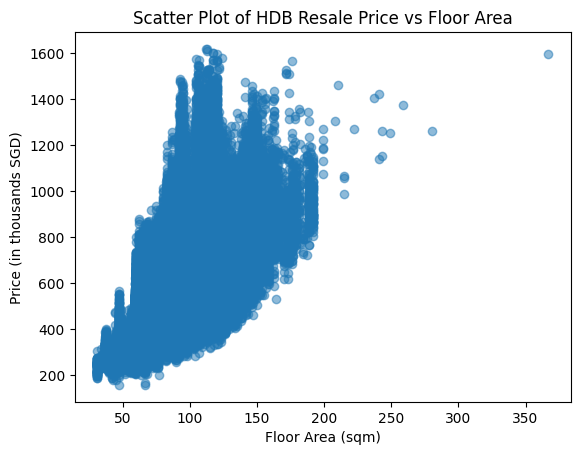

In [ ]:
# Scatter plot of price vs floor area
plt.scatter(floor_area, price, alpha=0.5)
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Price (in thousands SGD)')
plt.title('Scatter Plot of HDB Resale Price vs Floor Area')

# Correlation coefficient
correlation = np.corrcoef(floor_area, price)[0, 1]
print("Pearson Correlation coefficient between Floor Area and Price:", correlation)
spearman_corr = stats.spearmanr(floor_area, price)
print("Spearman Correlation coefficient between Floor Area and Price:", spearman_corr.correlation)

# Covariance Matrix
cov_matrix = np.cov(floor_area, price)
print("Covariance Matrix between Floor Area and Price:\n", cov_matrix)

Text(0.5, 1.0, 'Heatmap of Floor Area vs Price')

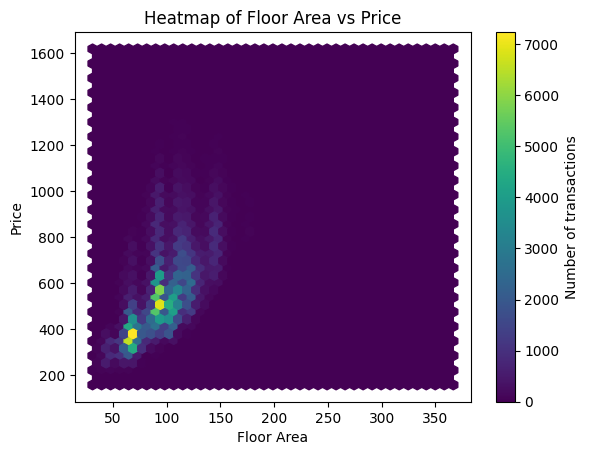

In [ ]:
plt.hexbin(floor_area, price, gridsize=40, cmap='viridis')
plt.colorbar(label='Number of transactions')
plt.xlabel('Floor Area')
plt.ylabel('Price')
plt.title('Heatmap of Floor Area vs Price')

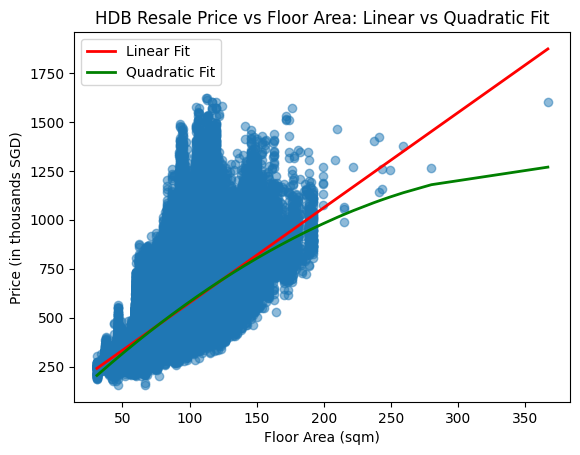

In [ ]:
# Fit linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = floor_area.values.reshape(-1, 1)
y = price.values

# Linear model
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)

# Polynomial model (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)

# Plot regression results
sort_idx = np.argsort(X.flatten())
X_sorted = X.flatten()[sort_idx]

linear_sorted = y_pred_linear[sort_idx]
poly_sorted   = y_pred_poly[sort_idx]
plt.scatter(floor_area, price, alpha=0.5)
plt.plot(X_sorted, linear_sorted, color='red', linewidth=2, label='Linear Fit')
plt.plot(X_sorted, poly_sorted, color='green', linewidth=2, label='Quadratic Fit')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Price (in thousands SGD)')
plt.title('HDB Resale Price vs Floor Area: Linear vs Quadratic Fit')
plt.legend()




In [ ]:
from sklearn.metrics import r2_score
r2_linear = r2_score(y, y_pred_linear)
r2_poly   = r2_score(y, y_pred_poly)
print("R-squared for Linear Model:", r2_linear)
print("R-squared for Quadratic Model:", r2_poly)


R-squared for Linear Model: 0.3926505431508195
R-squared for Quadratic Model: 0.3940053249235985
